<a href="https://colab.research.google.com/github/zhaokwit/XGBoost-for-PCB-Reflow/blob/main/XGBoost_for_PCB_Reflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Load Data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from google.colab import files

# Load data
file = files.upload()
df = pd.read_csv("Reflow_zone_temp_dataset.csv")
df.head()

Saving Reflow_zone_temp_dataset.csv to Reflow_zone_temp_dataset (3).csv


,PCB_Thickness_mm,Board_Length_mm,Board_Width_mm,Conveyor_Speed_cm_per_min,Copper_Weight_oz,Component_Count,0201_Resistors,0402_Inductors,Alum_Caps,0603_Caps,...,Zone_1_Temp_C,Zone_2_Temp_C,Zone_3_Temp_C,Zone_4_Temp_C,Zone_5_Temp_C,Zone_6_Temp_C,Zone_7_Temp_C,Zone_8_Temp_C,Zone_9_Temp_C,Zone_10_Temp_C
0,1.95,50.8,94.6,50.1,1,907,183,245,67,250,...,146.7,146.6,158.4,158.1,162.4,156.8,157.6,157.6,157.8,159.6
1,2.05,196.3,127.2,116.2,2,711,78,126,108,224,...,147.9,145.7,144.2,150.7,148.7,142.5,154.9,150.9,157.2,158.2
2,1.16,123.6,91.4,81.6,1,1207,293,194,158,273,...,133.7,141.3,134.4,134.9,138.9,137.6,142.3,136.0,137.0,144.1
3,1.72,158.4,74.4,113.9,1,802,71,117,118,214,...,147.1,153.4,153.7,151.5,155.7,151.9,153.6,156.9,158.8,158.7
4,1.98,173.1,120.3,81.8,1,792,98,190,211,158,...,148.2,149.1,153.5,149.6,154.5,154.7,159.8,153.5,153.6,159.7


In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.4 MB/s eta 0:00:00


[I 2025-04-06 04:44:10,100] A new study created in memory with name: no-name-67384f61-d38d-4d71-9af1-2e7f6f284e41
[I 2025-04-06 04:44:12,799] Trial 0 finished with value: 0.8093103170394897 and parameters: {'n_estimators': 413, 'max_depth': 3, 'learning_rate': 0.015576491694377264, 'subsample': 0.6831512175796559, 'colsample_bytree': 0.8703597527369268, 'gamma': 0.5018000478672133, 'reg_alpha': 0.8702996555137521, 'reg_lambda': 2.414442498765228, 'min_child_weight': 8.022230267823083}. Best is trial 0 with value: 0.8093103170394897.
[I 2025-04-06 04:44:33,150] Trial 1 finished with value: 0.6973275542259216 and parameters: {'n_estimators': 811, 'max_depth': 6, 'learning_rate': 0.0014837218475518212, 'subsample': 0.9619536348902867, 'colsample_bytree': 0.9771903933428381, 'gamma': 0.7148347488985551, 'reg_alpha': 9.612972087505474, 'reg_lambda': 7.208238346367959, 'min_child_weight': 3.6167032357733535}. Best is trial 0 with value: 0.8093103170394897.
[I 2025-04-06 04:44:36,210] Trial 2


Performance Metrics:
        Target    R²  MAE  RMSE Unit
 Zone_1_Temp_C 0.775 2.55  3.31   °C
 Zone_2_Temp_C 0.773 2.69  3.40   °C
 Zone_3_Temp_C 0.819 2.42  3.19   °C
 Zone_4_Temp_C 0.831 2.45  2.97   °C
 Zone_5_Temp_C 0.823 2.40  3.06   °C
 Zone_6_Temp_C 0.808 2.57  3.17   °C
 Zone_7_Temp_C 0.815 2.64  3.18   °C
 Zone_8_Temp_C 0.810 2.59  3.21   °C
 Zone_9_Temp_C 0.817 2.56  3.16   °C
Zone_10_Temp_C 0.846 2.32  2.78   °C

Average Performance Across All Zones:
Average R²: 0.812
Average MAE: 2.52°C
Average RMSE: 3.14°C


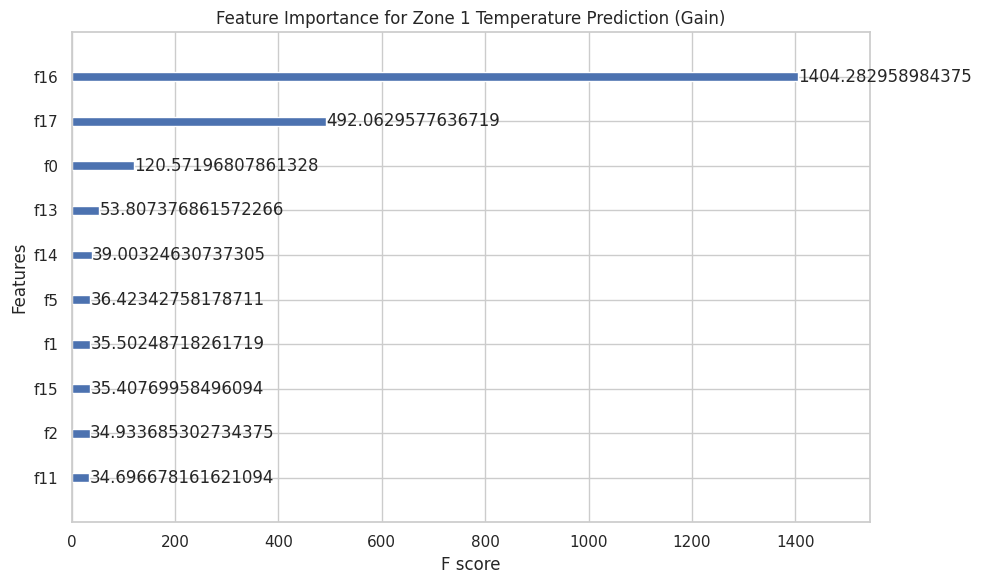

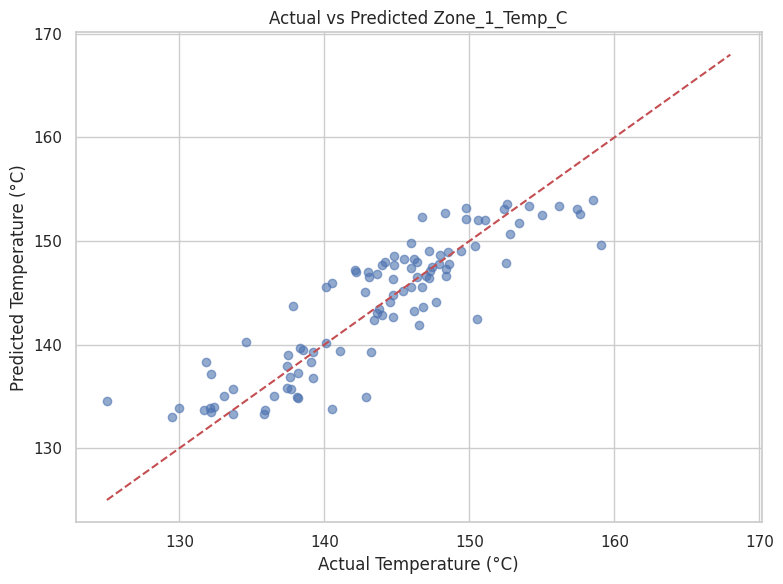

In [39]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import optuna
import matplotlib.pyplot as plt

# --------------------------
# 1. DATA PREPARATION
# --------------------------

# Features
X = df[['PCB_Thickness_mm', 'Board_Length_mm', 'Board_Width_mm',
        'Copper_Weight_oz', 'Component_Count', '0201_Resistors',
        '0402_Inductors', 'Alum_Caps', '0603_Caps', 'Connectors',
        'Paste_Type', 'Conveyor_Speed_cm_per_min']]

# Targets
y = df[['Zone_1_Temp_C', 'Zone_2_Temp_C', 'Zone_3_Temp_C',
        'Zone_4_Temp_C', 'Zone_5_Temp_C', 'Zone_6_Temp_C',
        'Zone_7_Temp_C', 'Zone_8_Temp_C', 'Zone_9_Temp_C',
        'Zone_10_Temp_C']]

# --------------------------
# 2. FEATURE ENGINEERING
# --------------------------
X = X.copy()
X['Board_Area'] = X['Board_Length_mm'] * X['Board_Width_mm']
X['Thermal_Load'] = X['Component_Count'] * X['Copper_Weight_oz']
X['Area_to_Thickness'] = X['Board_Area'] / X['PCB_Thickness_mm']
X['Component_Density'] = X['Component_Count'] / X['Board_Area']
X['Thermal_Exposure'] = X['Conveyor_Speed_cm_per_min'] * X['Board_Length_mm']  # Proxy for exposure time

# --------------------------
# 3. PREPROCESSING
# --------------------------
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = ['Paste_Type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

X_processed = preprocessor.fit_transform(X)
feature_names = np.concatenate([
    numeric_features,
    preprocessor.named_transformers_['cat'].get_feature_names_out(['Paste_Type'])
])

# --------------------------
# 4. MODEL TRAINING
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

# Hyperparameter tuning
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'random_state': 42
    }

    model = MultiOutputRegressor(xgb.XGBRegressor(**params))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Train final model
best_params = study.best_params
final_model = MultiOutputRegressor(
    xgb.XGBRegressor(**best_params, random_state=42)
)
final_model.fit(X_train, y_train)

# --------------------------
# 5. EVALUATION
# --------------------------
y_pred = final_model.predict(X_test)

# Metrics including RMSE
target_names = y.columns
metrics = []
for i, name in enumerate(target_names):
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
    metrics.append({
        'Target': name,
        'R²': round(r2, 3),
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'Unit': '°C'
    })

metrics_df = pd.DataFrame(metrics)
print("\nPerformance Metrics:")
print(metrics_df.to_string(index=False))

# Calculate average metrics across all zones
avg_r2 = metrics_df['R²'].mean()
avg_mae = metrics_df['MAE'].mean()
avg_rmse = metrics_df['RMSE'].mean()

print("\nAverage Performance Across All Zones:")
print(f"Average R²: {avg_r2:.3f}")
print(f"Average MAE: {avg_mae:.2f}°C")
print(f"Average RMSE: {avg_rmse:.2f}°C")

# --------------------------
# 6. VISUALIZATION
# --------------------------
# Feature importance for Zone 1 temperature
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(
    final_model.estimators_[0],
    ax=ax,
    importance_type='gain',
    title='Feature Importance for Zone 1 Temperature Prediction (Gain)',
    max_num_features=10
)
plt.tight_layout()
plt.show()

# Actual vs Predicted for Zone 1
plt.figure(figsize=(8, 6))
plt.scatter(y_test.iloc[:, 0], y_pred[:, 0], alpha=0.6)
plt.plot([y_test.min().min(), y_test.max().max()],
         [y_test.min().min(), y_test.max().max()],
         'r--')
plt.title(f'Actual vs Predicted {target_names[0]}')
plt.xlabel('Actual Temperature (°C)')
plt.ylabel('Predicted Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
# --------------------------
# 7. PREDICTION FUNCTION
# --------------------------
def predict_oven_temperatures(input_features, model=final_model, preprocessor=preprocessor):

    # Create a copy of input features and add default conveyor speed
    features = input_features.copy()
    features['Conveyor_Speed_cm_per_min'] = 60  # Default value (can be adjusted)

    # Create DataFrame with same structure as training data
    input_df = pd.DataFrame([features])

    # Apply feature engineering
    input_df['Board_Area'] = input_df['Board_Length_mm'] * input_df['Board_Width_mm']
    input_df['Thermal_Load'] = input_df['Component_Count'] * input_df['Copper_Weight_oz']
    input_df['Area_to_Thickness'] = input_df['Board_Area'] / input_df['PCB_Thickness_mm']
    input_df['Component_Density'] = input_df['Component_Count'] / input_df['Board_Area']
    input_df['Thermal_Exposure'] = input_df['Conveyor_Speed_cm_per_min'] * input_df['Board_Length_mm']

    # Preprocess the input
    processed_input = preprocessor.transform(input_df)

    # Make prediction
    predictions = final_model.predict(processed_input)

    # Convert to dictionary with zone names
    zone_names = ['Zone_1_Temp_C', 'Zone_2_Temp_C', 'Zone_3_Temp_C',
                 'Zone_4_Temp_C', 'Zone_5_Temp_C', 'Zone_6_Temp_C',
                 'Zone_7_Temp_C', 'Zone_8_Temp_C', 'Zone_9_Temp_C',
                 'Zone_10_Temp_C']

    return dict(zip(zone_names, predictions[0]))

# Example usage:
if __name__ == "__main__":
    # Example input (all features except conveyor speed)
    user_input = {
        'PCB_Thickness_mm': 1.6,
        'Board_Length_mm': 200,
        'Board_Width_mm': 150,
        'Copper_Weight_oz': 1,
        'Component_Count': 45,
        '0201_Resistors': 12,
        '0402_Inductors': 5,
        'Alum_Caps': 3,
        '0603_Caps': 8,
        'Connectors': 4,
        'Paste_Type': 'Sn-Pb'  # Must match categories used in training
    }

    # Get predictions
    predictions = predict_oven_temperatures(user_input)

    # Print results
    print("\nPredicted Oven Zone Temperatures:")
    for zone, temp in predictions.items():
        print(f"{zone}: {temp:.1f}°C")


Predicted Oven Zone Temperatures:
Zone_1_Temp_C: 134.8°C
Zone_2_Temp_C: 137.3°C
Zone_3_Temp_C: 139.5°C
Zone_4_Temp_C: 139.4°C
Zone_5_Temp_C: 138.9°C
Zone_6_Temp_C: 140.7°C
Zone_7_Temp_C: 142.5°C
Zone_8_Temp_C: 140.2°C
Zone_9_Temp_C: 144.7°C
Zone_10_Temp_C: 145.5°C
